# False positives, false negatives and the discrimination threshold

## Introduction
On kaggle our measure of success is usually our position on the leaderboard, which is calculated using the [accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html). This score gives a number indicating what ratio of predictions were correct: a score of 0 tells us that not one single classification was correct, and a score of 1 is a perfect classification. However, this is far from the whole story. 

One hardly ever scores a 0 or a 1, and a *confusion matrix* is a tool designed to help us understand a little better how well our classifier is performing. The confusion matrix  goes into a little more detail; this time it provides us with four values:
* The number of times our classifier produced **true negatives** (TN)
* The number of times our classifier produced **true positives** (TP)
* The number of times our classifier produced **false positives** (FP)
* The number of times our classifier produced **false negatives** (FN)

which scikit-learn returns in the following format, hence the name matrix (Note that there is no standard convention for arrangement of this matrix):

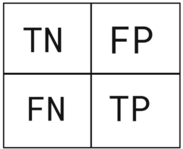

We can see now that the *accuracy score* is actually given by $\frac{(TN + TP)}{(TN + TP + FP +FN)}$, in other words, the true values divided by all the values. Another performance measure is the **$F_1$ score**, which is given by:

$$ F_1 = 2\frac{precision . recall}{precision + recall}$$
<br>
where the *precision* is given by $\frac{TP}{TP + FP}$, and *recall* by $\frac{TP}{TP + FN}$.


# Discrimination threshold
When using [scikit-learn](https://scikit-learn.org/stable/index.html) it is usual to implement the `predict()` method corresponding to our estimator of choice on the test set, here `X_test`, *i.e.*
> `predictions = classifier.predict(X_test)`

This will return a 1-dimensional [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) composed of 0's and 1's which correspond to our predictions. These are derived from looking at the probability estimates from the classifier, which are floating point numbers between 0 and 1.
If the probability estimate is less than `0.5`, the classification is deemed to be a `0`, and above `0.5` a `1`. This `0.5` is the natural choice for the *discrimination threshold*.
However, many estimators also come with a `predict_proba()` method too. This will return an array of the raw probability estimates. With this in hand we can now choose our own discrimination threshold, for example like this:

> `discrimination_threshold = 0.25
>  predictions = classifier.predict_proba(X_test)
>  predictions = (predictions[::,1] > discrimination_threshold )*1`

in which we slice the numpy array, use a comparison operator which creates a Boolean array composed of either `True` or `False`, and finally use the `*1` to convert the Boolean values onto `0`'s and `1`'s.

# False positives and false negatives
Why would we want to change the discrimination threshold when `0.5` seems eminently reasonable? Well there are circumstances where particularly wish to avoid having either false positives or false negatives. Let us provide and example; when testing for COVID-19, a false positive may lead to an individual having to be quarantined for a period, which may be inconvenient. However, a false negative my result in an infected individual subsequently mixing with uninfected people, and inadvertently spreading the virus. In this case a false negative would have far more undesirable consequences compared to a false positive result, and we may wish to compensate for this in our classification.
Another situation when one wishes to prioritise between false negatives and false positives is in cancer screening, which is the example we shall look at here.


# The data 
For data we shall use the ['Wisconsin' breast cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+&#40;Diagnostic&#41; ) which is one of the example datasets that can be found on  [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer).
# The model
For demonstration purposes the we shall perform a simple  [random forest classification](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). The parameters used here are far from optimal as our plan is actually *not* to aim for a good classification, but rather demonstrate the changes produced by varying the discrimination threshold.

In [ ]:
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sn
from   sklearn.metrics import accuracy_score
from   sklearn.metrics import f1_score
from   sklearn.metrics import precision_score
from   sklearn.metrics import recall_score
from   sklearn.metrics import confusion_matrix
from   sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#===========================================================================
# read in the dataset
#===========================================================================
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)

#===========================================================================
# split the data into train and test
#===========================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#===========================================================================
# perform the classification
#===========================================================================
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10,max_features=1,random_state=42)
classifier.fit(X_train, y_train);

# Example:
### Discrimination threshold = 0.5
First let us take a look at the confusion matrix obtained with the 'default' discrimination threshold of `0.5` of the `predict()` method:

In [ ]:
predictions = classifier.predict(X_test)

print("The precision score is: %.2f" % precision_score( y_test, predictions))
print("The recall score is: %.2f" % recall_score( y_test, predictions), "\n")
print("Accuracy score is: %.2f" % accuracy_score( y_test, predictions))
print("The F1 score is: %.2f" % f1_score( y_test, predictions))

cm = confusion_matrix( y_test , predictions )
plt.figure(figsize = (3,3))
sn.heatmap(cm, annot=True, annot_kws={"size": 25}, fmt="d", cmap="viridis", cbar=False)
plt.show()

we see that we have 1 false positive, and 4 false negatives.
### Discrimination threshold = 0.25

In [ ]:
discrimination_threshold = 0.25
predictions = classifier.predict_proba(X_test)
predictions = (predictions[::,1] > discrimination_threshold )*1

print("The recall score is: %.2f" % recall_score( y_test, predictions))
print("The precision score is: %.2f" % precision_score( y_test, predictions),"\n")
print("Accuracy score is: %.2f" % accuracy_score( y_test, predictions))
print("The F1 score is: %.2f" % f1_score( y_test, predictions))

cm = confusion_matrix( y_test , predictions )
plt.figure(figsize = (3,3))
sn.heatmap(cm, annot=True, annot_kws={"size": 25}, fmt="d", cmap="viridis", cbar=False)
plt.show()

we can now see that we have 8 false positives, but this time no false negatives (A *recall* of 1.00). However, we can see that our accuracy score has dropped from 0.97 to 0.94.

### Discrimination threshold = 0.75

In [ ]:
discrimination_threshold = 0.75
predictions = classifier.predict_proba(X_test)
predictions = (predictions[::,1] > discrimination_threshold )*1

print("The precision score is: %.2f" % precision_score( y_test, predictions))
print("The recall score is: %.2f" % recall_score( y_test, predictions), "\n")
print("Accuracy score is: %.2f" % accuracy_score( y_test, predictions))
print("The F1 score is: %.2f" % f1_score( y_test, predictions))

cm = confusion_matrix( y_test , predictions )
plt.figure(figsize = (3,3))
sn.heatmap(cm, annot=True, annot_kws={"size": 25}, fmt="d", cmap="viridis", cbar=False)
plt.show()

we can now see that we now have 12 false negatives, but no false positives (A *precision* of 1.00). This time our accuracy score has dropped even further, down to 0.92.

# 3. Discrimination threshold plot
We have looked at thresholds of `0.5` and as well as `0.25` and `0.75` by hand. However, thanks to the 
 [Discrimination Threshold Visualizer](https://www.scikit-yb.org/en/latest/api/classifier/threshold.html) from [Yellowbrick](https://www.scikit-yb.org/en/latest/) we can also automatically examine the range of values between 0 and 1, and see the results in a plot:

In [ ]:
from yellowbrick.classifier import DiscriminationThreshold
visualizer = DiscriminationThreshold(classifier, size=(1000, 500))

visualizer.fit(X_train, y_train)
visualizer.show();

# Conclusion
By varing the discrimination threshold we can reduce instances of either false positives or false negatives, depending on the priorities of the problem we are dealing with, although this may come at the cost of the overall performance of the classication, for example measured by the accuracy, or by the $F_1$ score.
# Related reading
* [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
* [False positives and false negatives](https://en.wikipedia.org/wiki/False_positives_and_false_negatives)
* [F1 score](https://en.wikipedia.org/wiki/F1_score)
* [Receiver operating characteristic curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
* [Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)

# Links
* ['Wisconsin' breast cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) 
* [Discrimination Threshold Visualizer](https://www.scikit-yb.org/en/latest/api/classifier/threshold.html) from [Yellowbrick](https://www.scikit-yb.org/en/latest/)
* [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html): this routine is analogous to the one used by kaggle to calculate your score on the leaderboard when you submit your file.
* [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html): this routine will calculate our confusion matrix.
* [sklearn.metrics.f1_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) which returns the $F_1$ score.